# Debugging the Feature Detection Code 

In [6]:

# === Imports ===
import os
from pathlib import Path
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [51]:

# Inline plots
%matplotlib inline

def imread_any(path):
    """
    Read an image as grayscale uint8, robust to 16-bit sources.
    Returns (gray_uint8, original_bgr).
    """
    if not Path(path).exists():
        raise FileNotFoundError(f"Image not found: {path}")
    # Read with unchanged depth to detect 16-bit
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Could not load image at {path}")
    # Keep a color copy (BGR) for overlays
    if img.ndim == 2:
        bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.ndim == 3:
        if img.shape[2] == 3:
            bgr = img.copy()
        elif img.shape[2] == 4:
            bgr = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        else:
            bgr = img[..., :3].copy()
    else:
        raise ValueError("Unexpected image dimensions.")

    # Convert to grayscale
    if img.ndim == 3:
        gray = img[..., 1]  # BGR -> take G
    else:
        gray = img

    # Normalize to uint8 if needed
    if gray.dtype != np.uint8:
        # Stretch to [0, 255]
        gray_u8 = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else:
        gray_u8 = gray
    return gray_u8, bgr

def show(title, image):
    """Quick imshow with Matplotlib."""
    plt.figure(figsize=(6,6))
    if image.ndim == 2:
        plt.imshow(image, cmap='gray')
    else:
        # Convert BGR->RGB for Matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


In [165]:
def local_z_binary(gray, window=41, k=0, dark=True, morph_open=9):
    """
    Local z-score thresholding.
    gray: single-channel image (uint8/float). Use the GREEN channel or pre-flattened image.
    window: odd window size for local stats (set ~2–4× pit diameter in px).
    k: number of std devs from local mean to consider a detection.
    dark: True -> detect dark blobs on bright background; False -> bright blobs.
    morph_open: optional cleanup kernel size (0 to skip).
    Returns: (binary_uint8, zmap_float32)
    """
    w = window if window % 2 == 1 else window + 1
    I = gray.astype(np.float32)

    # Local mean and std via box filter
    mu  = cv2.blur(I, (w, w))
    mu2 = cv2.blur(I * I, (w, w))
    sigma = np.sqrt(np.clip(mu2 - mu * mu, 1e-6, None))

    # z = (mu - I)/sigma for dark blobs; (I - mu)/sigma for bright blobs
    z = (mu - I) / (sigma + 1e-6) if dark else (I - mu) / (sigma + 1e-6)

    # Threshold to binary
    bin_img = (z > float(k)).astype(np.uint8) * 255

    # Optional speckle cleanup
    if morph_open and morph_open > 0:
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_open, morph_open))
        bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, ker)

    return bin_img, z


In [188]:

# === Feature Extraction (edited!!!) ===
def feature_extraction(
    img_gray,
    min_area=50,
    max_area=None,
    blur_ksize=5,
    thresh_method="otsu",  # "otsu" | "adaptive" | "fixed"
    fixed_thresh=128,
    invert=True,
    morph_open=0,      # kernel size in px; 0 = skip
    morph_close=0,     # kernel size in px; 0 = skip
    background="gaussian", bg_sigma=80, bg_ksize=101 #gaussian or tophat
):
    """
    Basic CR-39 pit candidate extraction using threshold + contour features.
    Returns: features (list of dicts), bin_img (binary image), contours (list of np.ndarray), debug (dict)
    """
    # Ensure 8-bit grayscale
    gray = (img_gray if img_gray.dtype==np.uint8
            else cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

#adding some code to try to fix the background flattening ie Subtract a heavily blurred background (or use a large-kernel top-hat) before thresholding.
    #if background == "gaussian":
    #    bg = cv2.GaussianBlur(gray, (0,0), sigmaX=bg_sigma, sigmaY=bg_sigma)
    #    gray = cv2.subtract(gray, bg)
    #elif background == "tophat":
    #    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (bg_ksize, bg_ksize))
    #    gray = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, ker)
    
    # Optional blur (helps Otsu/adaptive)
    k = max(3, int(blur_ksize) | 1)  # odd
    blur = cv2.GaussianBlur(gray, (k, k), 0)

    # Otsu and binary inversion Threshold

    #_, bin_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # we try using adaptive thresholding

    bin_img, zmap = local_z_binary(blur, window=81, k=2, dark=True, morph_open=3)
    #_, bin_img = cv2.threshold(thresh, 0, 255, cv2.THRESH_OTSU)


    # Morphology (optional)
    def _maybe_morph(binary, ksize, op):
        if ksize and ksize > 0:
            ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
            return cv2.morphologyEx(binary, op, ker)
        return binary

    bin_img = _maybe_morph(bin_img, morph_open,  cv2.MORPH_OPEN)
    bin_img = _maybe_morph(bin_img, morph_close, cv2.MORPH_CLOSE)

    # Contours
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rows = []
    h, w = gray.shape[:2]
    for idx, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area <= 0:
            continue
        if area < (min_area or 0):
            continue
        if max_area is not None and area > max_area:
            continue

        perim = cv2.arcLength(cnt, True)
        x, y, bw, bh = cv2.boundingRect(cnt)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = M["m10"]/M["m00"]
            cy = M["m01"]/M["m00"]
        else:
            cx = x + bw/2
            cy = y + bh/2

        # Equivalent diameter
        import math
        equiv_d = 2.0 * math.sqrt(area / math.pi)

        # Ellipse-based geometry
        major, minor, angle = None, None, None
        if len(cnt) >= 5:
            (ex, ey), (a1, a2), ang = cv2.fitEllipse(cnt)
            major, minor = (max(a1, a2), min(a1, a2))
            angle = float(ang)

        # Intensity stats inside contour (on original grayscale)
        mask = np.zeros_like(gray, dtype=np.uint8)
        cv2.drawContours(mask, [cnt], -1, 255, thickness=-1)
        pixels = gray[mask == 255]
        mean_int = float(np.mean(pixels)) if pixels.size else np.nan
        med_int  = float(np.median(pixels)) if pixels.size else np.nan
        max_int  = float(np.max(pixels)) if pixels.size else np.nan
        min_int  = float(np.min(pixels)) if pixels.size else np.nan

        circularity = (4.0 * math.pi * area / (perim * perim)) if perim > 0 else np.nan
        aspect = (bw / bh) if bh > 0 else np.nan

        rows.append({
            "id": idx,
            "area": float(area),
            "perimeter": float(perim),
            "equiv_diam": float(equiv_d),
            "bbox_x": int(x), "bbox_y": int(y), "bbox_w": int(bw), "bbox_h": int(bh),
            "centroid_x": float(cx), "centroid_y": float(cy),
            "major_axis": float(major) if major is not None else np.nan,
            "minor_axis": float(minor) if minor is not None else np.nan,
            "ellipse_angle_deg": float(angle) if angle is not None else np.nan,
            "circularity": float(circularity),
            "aspect_ratio": float(aspect),
            "mean_intensity": mean_int,
            "median_intensity": med_int,
            "max_intensity": max_int,
            "min_intensity": min_int,
        })

    debug = {
        "gray": gray,
        "blur": blur,
    }
    return rows, bin_img, contours, debug

In [212]:

def make_overlay(original_bgr, features, draw="equiv_circle", thickness=2):
    """
    Draw detections on the ORIGINAL BGR image.
    draw: "equiv_circle" | "bbox" | "ellipse"
    """
    overlay = original_bgr.copy()
    h, w = overlay.shape[:2]
    for row in features:
        cx = int(round(row["centroid_x"]))
        cy = int(round(row["centroid_y"]))
        if draw == "equiv_circle":
            r = max(1, int(round(row["equiv_diam"] / 2.0)))
            cv2.circle(overlay, (cx, cy), r, (0, 255, 0), thickness)
            cv2.circle(overlay, (cx, cy), 1, (0, 0, 255), -1)  # center dot
        elif draw == "bbox":
            x, y = int(row["bbox_x"]), int(row["bbox_y"])
            bw, bh = int(row["bbox_w"]), int(row["bbox_h"])
            cv2.rectangle(overlay, (x, y), (x+bw, y+bh), (255, 0, 0), thickness)
        elif draw == "ellipse":
            # Reconstruct ellipse if values exist
            if not np.isnan(row["major_axis"]) and not np.isnan(row["minor_axis"]):
                center = (cx, cy)
                #axes = (int(round(row["major_axis"]/2)), int(round(row["minor_axis"]/2)))
                axes = (int(round(row["minor_axis"]/2)), int(round(row["major_axis"]/2)))
                angle = float(row["ellipse_angle_deg"]) if not np.isnan(row["ellipse_angle_deg"]) else 0.0
                cv2.ellipse(overlay, center, axes, angle, 0, 360, (255, 0, 0), thickness)
            else:
                # fallback to circle if ellipse unavailable
                r = max(1, int(round(row["equiv_diam"] / 2.0)))
                cv2.circle(overlay, (cx, cy), r, (0, 255, 0), thickness)
    return overlay


In [218]:

# === Configuration ===
# Update this to your image path (you can upload the image in the Files tab or to /mnt/data)
IMAGE_PATH = r"C:\Users\rocks\OneDrive\Documents\MIT\RA\CR39\feature_recognition\selection-trackfinding\33_101.jpg"  # <- change me

# Default parameters — tune here or directly inside feature_extraction
PARAMS = dict(
    min_area=30,
    max_area=2000,     # e.g. 2000 to reject large artifacts
    blur_ksize=7,
    thresh_method="otsu",  # "otsu" | "adaptive" | "fixed"
    fixed_thresh=128,
    invert=True,
    morph_open=0,
    morph_close=0,
)

DRAW_STYLE = "ellipse"  # "equiv_circle" | "bbox" | "ellipse"
SAVE_OVERLAY_PATH = "/mnt/data/overlay_debug.png"
SAVE_FEATURES_CSV  = "/mnt/data/features_debug.csv"


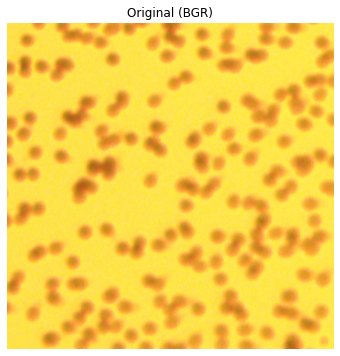

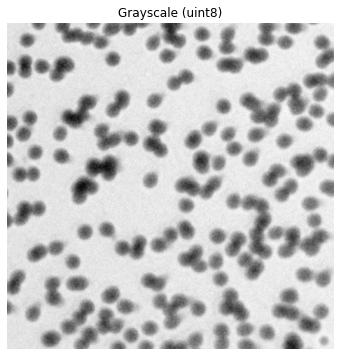

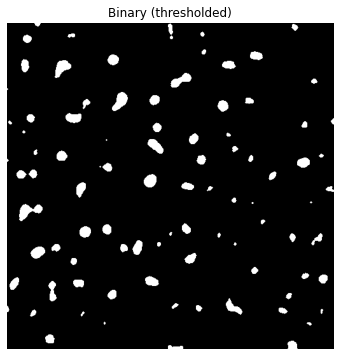

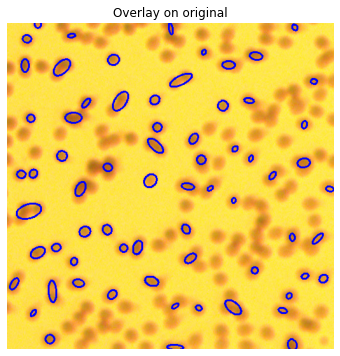

Detected 68 candidates.


True

In [219]:
# === Run on one image ===
gray, bgr = imread_any(IMAGE_PATH)
show("Original (BGR)", bgr)
show("Grayscale (uint8)", gray)

features, bin_img, contours, dbg = feature_extraction(gray, **PARAMS)
df = pd.DataFrame(features).sort_values("area", ascending=False).reset_index(drop=True)

show("Binary (thresholded)", bin_img)
overlay = make_overlay(bgr, features, draw=DRAW_STYLE, thickness=2)
show("Overlay on original", overlay)

print(f"Detected {len(features)} candidates.")
# Save outputs
cv2.imwrite(SAVE_OVERLAY_PATH, overlay)
#df.to_csv(SAVE_FEATURES_CSV, index=False)

#print("Saved:")
#print("  Overlay ->", SAVE_OVERLAY_PATH)
#print("  Features ->", SAVE_FEATURES_CSV)

# Peek at a few rows
#df.head(10)
